In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

# the Bayesian stuff
import bambi as bmb
import pymc as pm

# the frequentist stuff 
import statsmodels.api as sm

# plotting
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# RNG
rng = np.random.default_rng(seed=20240704)

## Example 2: Model misspecification - The importance of model checking

We now consider another artificial problem, but this time, where our model is actually wrong.

Suppose we have the following random sample of data:

In [2]:
N = 1000
Nsub = 100
x1 = np.random.normal(loc=[0.5,0.2], scale=[0.8,0.9], size=(N,2))
x2 = np.random.normal(loc=[1.5,2.5],scale=[0.6,0.6],size=(N,2))
x3 = np.random.normal(loc=[2.0,1.5],scale=[0.7,0.6],size=(N,2))
X = np.concatenate([x1,x2,x3], axis=0)

In [3]:
def subsample(lo=0,hi=1,n=1):
    return np.random.choice(range(lo,hi), size=n, replace=False)

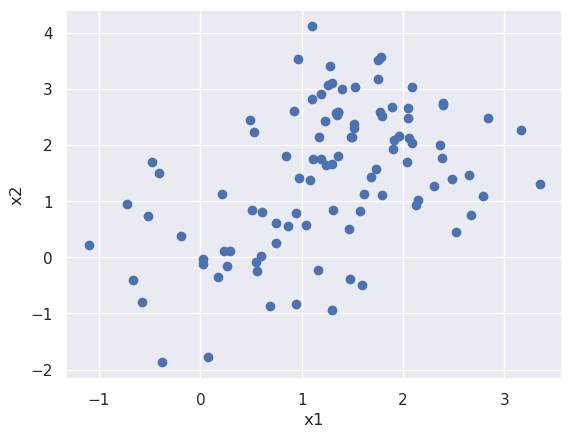

In [4]:
inds = subsample(hi=N*3,n=Nsub)
plt.scatter(X[inds,0],X[inds,1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

It's clear that there is a lot of variance, but we might be inclined to think there is a linear relationship between the two variables.

Unbenknownst to our hypothetical selves, the "true" data distribution is a 2-dimensional mixture of Gaussians:

$$
X \sim \text{UniformMixture}[\mathcal{N}(\vec{\mu}_1,\vec{\sigma}_1),\mathcal{N}(\vec{\mu}_2,\vec{\sigma}_2),\mathcal{N}(\vec{\mu}_3,\vec{\sigma}_3)]
$$

where $X \in \mathbb{R}^2$

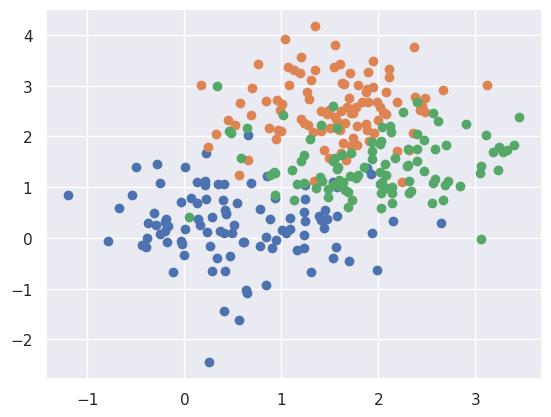

In [5]:
inds = subsample(hi=N,n=Nsub)
plt.scatter(x1[inds,0],x1[inds,1])
plt.scatter(x2[inds,0],x2[inds,1])
plt.scatter(x3[inds,0],x3[inds,1]);

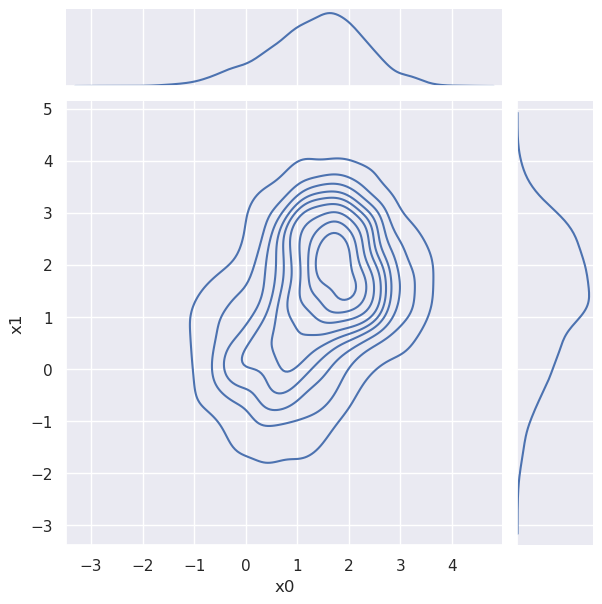

In [6]:
sns.jointplot(x=X[:,0], y=X[:,1], kind="kde")
plt.xlabel("x0")
plt.ylabel("x1");

Let's suppose we go ahead and naively fit a linear regression.

In [7]:
# take subsample for fitting
inds = subsample(hi=N*3,n=Nsub)
# fit OLS
y, x = X[inds,1],X[inds,0]
x_ = sm.add_constant(x)
res = sm.OLS(y,x_).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.359
Date:                Mon, 26 Aug 2024   Prob (F-statistic):             0.0394
Time:                        07:50:36   Log-Likelihood:                -153.08
No. Observations:                 100   AIC:                             310.2
Df Residuals:                      98   BIC:                             315.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0359      0.174      5.957      0.000       0.691       1.381
x1             0.2082      0.100      2.088      0.039       0.010       0.406
==============================================================================
Omnibus:                        6.031   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                5.428
Skew:                          -0.536   Prob(JB):                       0.0663
Kurtosis:                       3.393   Cond. No.                         3.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice that $p << 0.05$ and we very clearly reject the null hypothesis.

There are *some* red flags (low $R^2$ and high omnibus) but these aren't necessarily out of the ordinary.

Of course we can be similarly naive with a Bayesian model.

Note that we here use `bambi` to very easily set up and fit a linear model.

In [8]:
import bambi as bmb

data_example2 = pd.DataFrame(X, columns=["x0","x1"])
linear_model = bmb.Model("x1 ~ x0", data_example2.iloc[inds])
linear_model

       Formula: x1 ~ x0
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.3118, sigma: 4.3981)
            x0 ~ Normal(mu: 0.0, sigma: 2.5218)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.143)

It is good practice to first do a prior predictve check and see if anything is obviously amiss.

In [9]:
linear_model.build()
prior_samples = linear_model.prior_predictive(draws=100)

Sampling: [Intercept, x0, x1, x1_sigma]


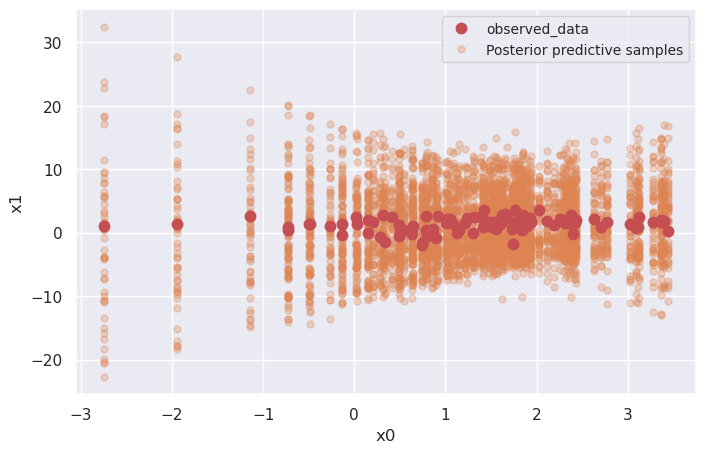

In [10]:
az.plot_lm("x1", prior_samples, y_hat=prior_samples.prior_predictive.x1, x=data_example2.x0.iloc[inds], figsize=(8,5));
plt.legend(loc='best', prop={'size': 10})
plt.show()

The prior is clearly too diffuse and could be made tighter, but otherwise the prior clearly covers the observations. Note, however, the discrepancies in the distribution of the data along the `x1` dimension. This is a red flag!

Let's go ahead and fit the model to see what we get.

In [11]:
inference_data = linear_model.fit(draws=1000, random_seed=1234)
# generate posterior predictive samples
linear_model.predict(inference_data, kind="pps");
# summarize posterior
az.summary(inference_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x1_sigma, Intercept, x0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.035,0.176,0.701,1.366,0.002,0.002,6357.0,3038.0,1.0
x0,0.209,0.101,0.027,0.405,0.001,0.001,6572.0,2813.0,1.0
x1_sigma,1.138,0.085,0.968,1.292,0.001,0.001,5517.0,2879.0,1.0
x1_mean[0],0.980,0.198,0.604,1.347,0.002,0.002,6412.0,3225.0,1.0
x1_mean[1],1.518,0.149,1.235,1.791,0.002,0.001,6067.0,2926.0,1.0
...,...,...,...,...,...,...,...,...,...
x1_mean[95],1.363,0.115,1.140,1.573,0.002,0.001,5558.0,2974.0,1.0
x1_mean[96],1.414,0.122,1.176,1.638,0.002,0.001,5688.0,2964.0,1.0
x1_mean[97],1.745,0.236,1.325,2.212,0.003,0.002,6344.0,3174.0,1.0
x1_mean[98],1.343,0.113,1.127,1.553,0.002,0.001,5520.0,2848.0,1.0


We can see from the posterior predictive samples of the linear model that something is off. The expected distribution of predictions looks very different from the actual data!

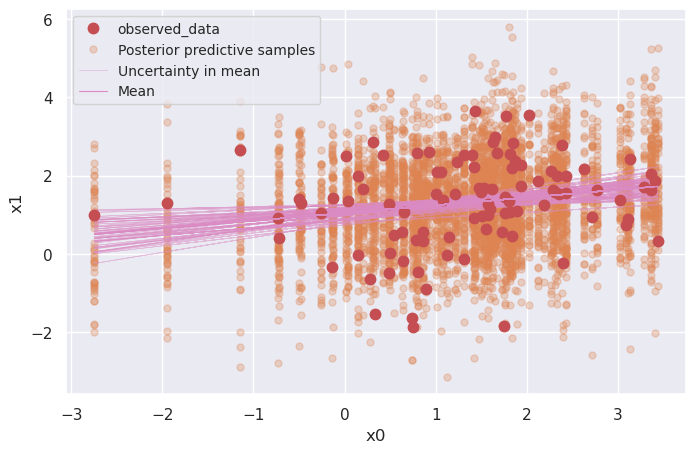

In [12]:
az.plot_lm("x1", inference_data, y_model="x1_mean", x=data_example2.x0.iloc[inds], figsize=(8,5));
plt.legend(loc='best', prop={'size': 10})
plt.show()

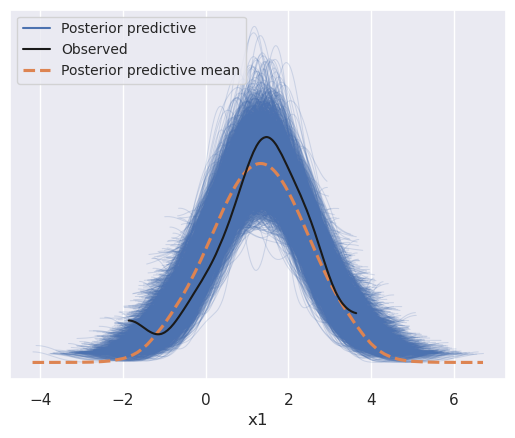

In [13]:
az.plot_ppc(inference_data, group="posterior", observed=True, random_seed=1234);
plt.legend(loc='upper left', prop={'size': 10})
plt.show()

#### Exercise

Try building a new model that models the data as a Gaussian mixture. Compare the posterior predictive check plots between the new model and the previous one.

You can refer to [this example](https://www.pymc.io/projects/examples/en/latest/mixture_models/gaussian_mixture_model.html) in the pymc docs to get started.

Note that you will need to write the pymc model directly rather than using bambi.